# Potentials Tutorial

This jupyter notebook serves as a tutorial on how to compute potentials and actions using the BFE files (Arora et al. 2021, in prep) made via Agama for the FiRE 2 suite of cosmological simulations. 
The potential files are simple INI text files that contain a Potential class for each expansion.

You will require the present day simulation snapshot files along with the following modules:

1. [Agama](https://github.com/GalacticDynamics-Oxford/Agama)   
2. [gizmo_analysis](https://bitbucket.org/awetzel/gizmo_analysis/src/master/)  
3. [utilities](https://bitbucket.org/awetzel/utilities/src/master/)  

In [8]:
##Import packages
import numpy as np
import agama
import gizmo_analysis as ga
import utilities as ut

import matplotlib.pyplot as plt


from gala.units import UnitSystem
import time
from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u

import jax
import jax.numpy as jnp

#from jax.config import config
jax.config.update("jax_enable_x64", True)


In [9]:
#Picking a sample simulation and a snapshot. 
#sim_dir = f'/mnt/ceph/users/firesims/fire2/metaldiff/m12i_res7100/'
sim_dir = f'/groups/astro/sapearso/Jake/FIRE/data/m12m_res7100/'
nsnap = 600

# #Read using gizmo
# part = ga.io.Read.read_snapshots(species=['star'],
#                                 snapshot_values=nsnap,
#                                 simulation_directory=sim_dir,
#                                 #snapshot_directory='output_accel',
#                                 particle_subsample_factor=1,
#                                 assign_hosts=True,
#                                 assign_hosts_rotation=True)

In [10]:
#part.host## host properties

In [11]:
##Find some real stars, simulated stars can be used as well
# pos_stars = part['star'].prop("host.distance.principal")##stellar positions with respect to the host. 
# dist_stars = part['star'].prop("host.distance.total")##stellar dist with respect to the host.
# vel_stars = part['star'].prop("host.velocity.principal")

Now these distances and velocities can be used to compute potentials and actions in the correct frame 

## READING POTENTIAL 

Currently there are 2 symmetry choices available in our potenital model computed for the highest pole order 4:

1. axisymmetry (axi)
2. no symmetry (none)

In [12]:
# Crucial to set units below for this to work!
agama.setUnits(mass=1,length=1,velocity=1)

In [13]:
symmlabel = {'a':'axi','n':'none'}
##pick the required symmetry and multipole coef. 
mult_l = 4 ##Only one that exists right now. lol.
sym = 'a'#'a' ## axisymmetry, gives the ability to compute actions 

##Note the directory address for the expansion files
# print('Loading multipole and cubicspline files')
# pxr_DM = agama.Potential(file=f'{sim_dir}potential/10kpc/{nsnap}.dark.{symmlabel[sym]}_{mult_l}.coef_mul_DR') #DM halo + cold gas (multipole expansion)
# pxr_bar = agama.Potential(file=f'{sim_dir}potential/10kpc/{nsnap}.bar.{symmlabel[sym]}_{mult_l}.coef_cylsp_DR') # bar + hot gas (CubicSpline expansion)
# print('Files loaded!')
# pot_model = agama.Potential(pxr_DM,pxr_bar)
# pot_model## a potential class object that can be used to determine potential, density and other properties for our model

print('Loading multipole and cubicspline files')
pxr_DM = agama.Potential(file=f'{sim_dir}/{nsnap}.dark.{symmlabel[sym]}_{mult_l}.coef_mul_DR') #DM halo + cold gas (multipole expansion)
pxr_bar = agama.Potential(file=f'{sim_dir}/{nsnap}.bar.{symmlabel[sym]}_{mult_l}.coef_cylsp_DR') # bar + hot gas (CubicSpline expansion)
print('Files loaded!')
pot_model = agama.Potential(pxr_DM,pxr_bar)
pot_model## a potential class object that can be used to determine potential, density and other properties for our model

Loading multipole and cubicspline files
Files loaded!


CompositePotential{ Multipole, CylSpline } (symmetry: Axisymmetric)

Text(0, 0.5, 'Potential ($kpc^2/Gyr^2$)')

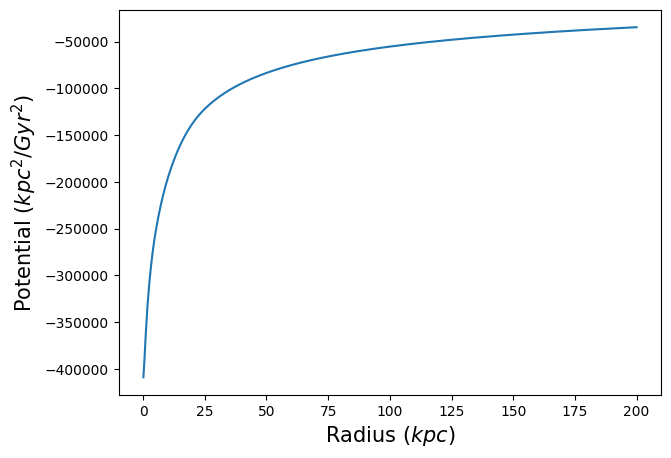

In [14]:
##Potential profile for simulated positions
plt.figure(figsize=(7,5))
simulated_pos = (np.vstack((np.linspace(0.1,200,600),0*np.linspace(0.1,200,600),0*np.linspace(0.1,200,600)))).T
plt.plot(simulated_pos[:,0],pot_model.potential(simulated_pos))
plt.xlabel(r'Radius ($kpc$)',fontsize=15)
plt.ylabel(r'Potential ($kpc^2/Gyr^2$)',fontsize=15)
#plt.sav

In [15]:
pot_model.enclosedMass(600)/10**12

1.8093916609520446

(600,)


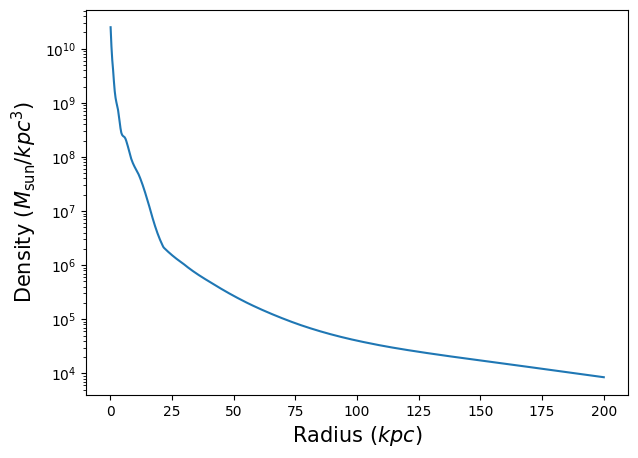

In [16]:
##Potential profile for simulated positions
plt.figure(figsize=(7,5))
simulated_pos = (np.vstack((np.linspace(0.1,200,600),0*np.linspace(0.1,200,600),0*np.linspace(0.1,200,600)))).T
plt.plot(simulated_pos[:,0],pot_model.density(simulated_pos))
plt.xlabel(r'Radius ($kpc$)',fontsize=15)
plt.ylabel(r'Density ($M_{\rm sun}/kpc^3$)',fontsize=15)
plt.yscale('log')
BFE_density = pot_model.density(simulated_pos)
print(BFE_density.shape)

In [17]:
# # Integrate the above to see if I get out the right numbr!
# import scipy
# r = np.linspace(0.1, 600, 600)
# simulated_pos1 = np.vstack((r, 0*r, 0*r)).T
# density = pot_model.density(simulated_pos1)
# mass_element = 4 * np.pi * r**2 * density
# total_mass = np.trapz(mass_element, r)
# print(f"Total mass: {total_mass:.3e}")

In [18]:
# Now need agama FIRE-m12m potential in density 
simulated_pos.shape

(600, 3)

## Added by SP
Now going to do chi-square minimaziation for Jake's potential with this FIRE one

In [10]:

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt,PIDController,DiscreteTerminatingEvent, DirectAdjoint, RecursiveCheckpointAdjoint
import JaxStreams_Information as JaxStreams 

In [11]:
#helper function for nfw
@jax.jit
def get_nfw_rho0(M,r_s):
    c_NFW = 15. # following https://arxiv.org/pdf/2211.04495
    denom = jnp.log(1. + c_NFW) - (c_NFW/(1+c_NFW))
    fac = 1./denom
    rho0 = (M/(4*jnp.pi*r_s**3))*fac
    return rho0
np.log10(get_nfw_rho0(3e12,22.))

2024-10-04 16:29:35.557400: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


7.086986282014672

In [13]:
interp_func = jnp.load('general_nfw_interp.npy',allow_pickle=True).item()

In [18]:
# define Chi2
from scipy.optimize import minimize

# BFE_density: array of observed values (the BFE density)
# NWF_density: function that calculates expected values (the NWF density) given parameters

def chi_square(params, BFE_density, NWF_density):
    # Calculate expected values using the current parameters
    expected_data = NWF_density(params)
    #print(expected_data.shape)
    # Ensure there are no zeros in the expected data to avoid division by zero
    #expected_data = np.clip(expected_data, 1e-10, None)
    expected_data = np.clip(expected_data, 1e-10, None)
    # Calculate chi-square statistic
    chi2 = np.sum((BFE_density - expected_data)**2)
    return chi2

In [20]:
def NWF_density(params):
    # params might include mean, sigma, and amplitude for a Gaussian model
    # amplitude, mean, sigma = params
    
    # # Generate the expected data as a Gaussian distribution
    # x = np.linspace(0, 10, len(BFE_density))  # or based on the BFE density's x-values
    # expected_data = amplitude * np.exp(-(x - mean)**2 / (2 * sigma**2))
    log10_m_halo, r_s, gamma, beta = params
    M = 10**log10_m_halo


    pot_disk = JaxStreams.MiyamotoNagaiDisk(m=5e10, a=3, b=0.2,units=usys)
    

    #rho0 = get_nfw_rho0(M,r_s)
    #print(rho0)


    #try to hard code instead 
    #[6e12, 22, 3.0, 1.0]
    rho0 = get_nfw_rho0(M,r_s)
    pot_halo = JaxStreams.GeneralNFWPotential(rho0 = rho0, r_s=r_s, 
                                     gamma=gamma, beta=beta, interp_func=interp_func,
                                              units=usys)
    #pot_halo = JaxStreams.GeneralNFWPotential(rho0 = rho0, r_s=r_s, 
     #                                gamma=gamma, beta=beta, interp_func=interp_func,
      #                                        units=usys)


    potential_list = [pot_disk,pot_halo]
    pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)
    #print(pot)

    
    #check with Jake that time is OK and that I'm collapsing 3D to 1D okay for BFE comparison
    expected_data  = jax.vmap(pot.density,in_axes=(0,None))(simulated_pos,0.0)
    #expected_data  = pot_halo
    #expected_data = pot_halo.density(simulated_pos, t=0)

    # Integrate the above to see if I get out the right numbr!
  
    # r = np.linspace(0.1, 200, 200)
    # simulated_pos1 = np.vstack((r, 0*r, 0*r)).T
    # #density = pot_model.density(simulated_pos1)
    # mass_element = 4 * np.pi * r**2 * expected_data
    # total_mass = np.trapz(mass_element, r)
    # print(f"Total mass: {total_mass:.3e}")
    
    return expected_data

In [21]:
#interp_func(1.5,1.,3.)#*(self.r_s**2)

Array(0.54968259, dtype=float64)

In [63]:
#test = NWF_density(params_initial)
# Initial guesses for parameters M, r_s, gamma, beta 
params_initial = [12., 16, 1., 3.0]

In [22]:

#log10_m_halo', dist=( 11.5,13.5)
# Minimize the chi-square function to find best-fit parameters
result = minimize(chi_square, params_initial, args=(BFE_density, NWF_density), bounds=(11.5,13.5),(10,22),(0,2),(2,4))
#change the method, dofferemt optimizer, bounds 

# Extract the best-fit parameters
best_fit_params = result.x

# Print the best-fit parameters and the minimum chi-square value
print("Best-fit parameters:", best_fit_params)
print("Minimum chi-square value:", result.fun)

KeyboardInterrupt: 

In [23]:
#bestfit_NFW_dens = NWF_density(best_fit_params)
bestfit_NFW_dens = NWF_density(params_initial)

(600,)


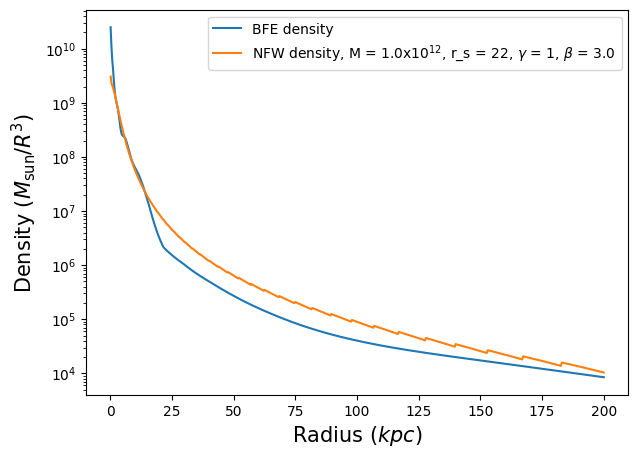

In [26]:
##Potential profile for simulated positions
plt.figure(figsize=(7,5))
#simulated_pos = (np.vstack((np.linspace(0.1,200,200),0*np.linspace(0.1,200,200),0*np.linspace(0.1,200,200)))).T
plt.plot(simulated_pos[:,0],pot_model.density(simulated_pos), label = 'BFE density')
plt.plot(simulated_pos[:,0],bestfit_NFW_dens, label = 'NFW density, M = ' +str(np.round(params_initial[0]/10**(12),2))\
         +r'x$10^{12}$, r_s = ' +str(np.round(params_initial[1],1)) +r', $\gamma$ = ' +str(np.round(params_initial[2],1)) +\
            r', $\beta$ = ' +str(np.round(params_initial[3],1)) )
# plt.plot(simulated_pos[:,0],bestfit_NFW_dens, label = 'NFW density, M = ' +str(np.round(best_fit_params[0]/10**(12),2))\
#          +r'x$10^{12}$, r_s = ' +str(np.round(best_fit_params[1],1)) +r', $\gamma$ = ' +str(np.round(best_fit_params[2],1)) +\
#             r', $\beta$ = ' +str(np.round(best_fit_params[3],1)) )
plt.xlabel(r'Radius ($kpc$)',fontsize=15)
plt.ylabel(r'Density ($M_{\rm sun}/R^3$)',fontsize=15)
plt.yscale('log')
plt.legend()
BFE_density = pot_model.density(simulated_pos)
print(BFE_density.shape)

In [19]:
# def pot_dens_chisquare( log10_m_disk, a_disk, b_disk, log10_m_halo, r_s, gamma, beta):

#     params = {'m_disk':10**log10_m_disk, 'a_disk': a_disk, 'b_disk': b_disk, 'M': 10**log10_m_halo,
#                           'r_s': r_s, 'gamma': gamma, 'beta':beta}

#     pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
#                                        b=params['b_disk'],units=usys)
#     rho0 = get_nfw_rho0(params['M'],params['r_s'])
    
#     pot_halo = JaxStreams.GeneralNFWPotential(rho0 = rho0, r_s=params['r_s'], 
#                                      gamma=params['gamma'], beta=params['beta'], interp_func=interp_func,
#                                               units=usys)

    
#     potential_list = [pot_disk,pot_halo]
#     pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)
#     return pot
#     #decide on spacing to compare to fire
#     # R_dens = np.linspace()
#     #density = pot.density()
#     # below added by SP
#     # Now get denisty of potential and chi-square minimize ...?

# pot_test = pot_dens_chisquare(jnp.log10(5e10),3.0,0.2,12,22.0,1,3)
# #test which chi-square minimizes:
# #'log10_m_halo', dist=( 11,13.5)
# #'r_s', dist=( 12.,30.)
# #'gamma', dist=( 0.,2.)
# #'beta', dist=( 2.,4.)
# # a_disk=3.0,b_disk=0.2,log10_m_halo=13.0,r_s=22.0,gamma=1.,beta=3.


In [20]:
# ##Potential profile for simulated positions
# plt.figure(figsize=(7,5))
# simulated_pos = (np.vstack((np.linspace(0.1,30,200),0*np.linspace(0.1,30,200),0*np.linspace(0.1,30,200)))).T
# plt.plot(simulated_pos[:,0],pot_test.density(simulated_pos))
# plt.xlabel(r'Radius ($kpc$)',fontsize=15)
# plt.ylabel(r'Density ($M_{\rm sun}/R^3$)',fontsize=15)

Note that potential can be adjusted with a constant additive to be 0 at infinity

## Potential and actions of stars within 30 kpcs

In [21]:
star_potential = pot_model.potential(pos_stars[dist_stars<30])##Finds the potential of stars within 30 kpc
print(f'Potential shape: {np.shape(star_potential)}')

##Computing Cylindrical Actions for stars within 30 kpcs
particles = np.hstack((pos_stars[dist_stars<30], vel_stars[dist_stars<30])) ##make this object for action space 
print("Starting action finder")
actFinder = agama.ActionFinder(pot_model)
print("Finding actions")
cyl_actions_space = actFinder(particles[:,0:6])
print("Actions calculated")
print(f'Action space shape: {np.shape(cyl_actions_space)}')

NameError: name 'pos_stars' is not defined

Text(0, 0.5, '$J_z$ $({kpc}^2 {Myr}^{-1})$')

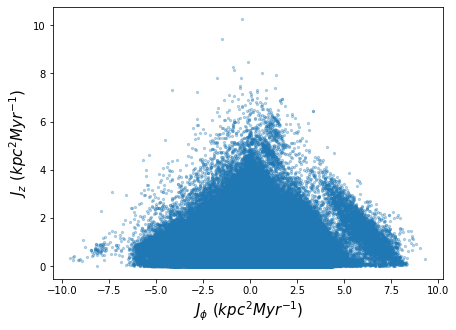

In [8]:
plt.figure(figsize=(7,5))
plt.scatter(cyl_actions_space[:,2]/1000,cyl_actions_space[:,1]/1000,alpha=0.3,s=5)
plt.xlabel(r'$J_\phi$ $({kpc}^2 {Myr}^{-1})$',fontsize=15)
plt.ylabel(r'$J_z$ $({kpc}^2 {Myr}^{-1})$',fontsize=15)

Contact info:   
EMAIL - arora125@sas.upenn.edu  
SLACK - Arpit Arora (Galaxy Dynamics @ UPenn, FIRE Simulation Project) 


Citation: (Arora et al. 2021, in prep)